### 분산 분석
- 선형회귀분석의 결과가 얼마나 좋은지는 단순히 잔차제곱합(RSS)으로 평가할 수 없다,
- 분산분석(ANOVA)은 종속변수의 분산과 독립변수의 분산간의 관계를 사용하여 선형회귀분석의 성능을 평가하고자 하는 방법이다.
- TSS = ESS + RSS

In [3]:
from sklearn.datasets import make_regression
import pandas as pd
import statsmodels.api as sm

X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

In [4]:
print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared) # TSS = ESS + RSS인걸 알 수 있다.

TSS =  291345.7578983061
ESS =  188589.61349210914
RSS =  102754.33755137536
ESS + RSS =  291343.9510434845
R squared =  0.6473091780922584


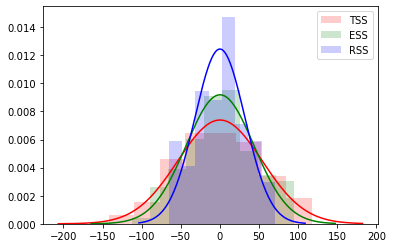

In [8]:
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
sns.distplot(y,
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"},
             label="TSS")
sns.distplot(result.fittedvalues,
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"},
             label="ESS")
sns.distplot(result.resid,
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"},
             label="RSS")
plt.legend()
plt.show()

### 결정계수
- 분산 관계식에서 모형의 성능을 나태내는 결정계수 R^2을 정의할 수 있다.
- R^2 = 1- RSS / TSS = ESS / TSS

### 회귀분석 F-검정과 분산 분석의 관계
- 이전에 F-검정을 배운적이 있다. 그때 귀무가설을 모든 가중치 값을 0으로 해서 p-value비교로 모델 비교를 할 수 있다고 배웠다.
- 그럼 귀무가설을 결정계수(R^2) = 0이라고 하여 F-검정할 수 있을것이다.
- (ESS/K-1) / (RSS/N-K) ~ F(K-1, N-K)

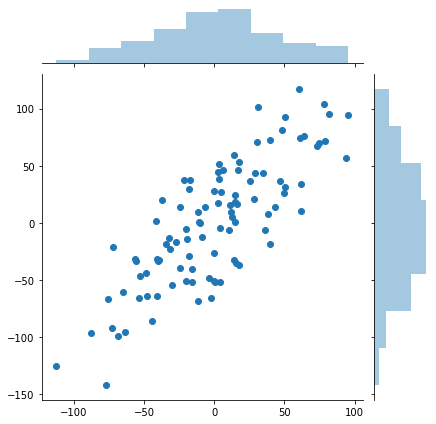

In [10]:
# 결정계수와 상관계수
# y와 예측한 y의 상관계수의 제곱한 값이 결정계수의 값과 같다.
sns.jointplot(result.fittedvalues, y)
plt.show() 

### 상수항이 없는 모형인 경우
- 일단 상수항을 안쓰는 경우는 없다. 그치만 만약에 상수항 없이 한다면
- 상수항이 없는 경우 ESS값이 TSS값보다 더 커질 수 있다. 그럼 결정계수가 1이 넘는다.
- 그래서 TSS = y의 평균을 빼서 제곱하지 않고 y자신의 제곱합으로 구한다.
- 따라서 상수항이 있는 모델과 상수항이 없는 모델간의 결정계수 비교 하면 안된다.

In [11]:
X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

In [14]:
result2.rsquared # 이 경우에는 결정계수가 낮지만 결정게수가 높게 나올떄도 있다. 

0.18768724705943896

### F 검정을 이용한 모형 비교
- 전체 모형 : y = w0 + w1x1 + w2x2 + w3x3
- 부분 모형 : Y = w0 + w1x1
- 귀무가설 Ho : w2 = w3 = 0

In [15]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
dfX_boston = sm.add_constant(dfX0_boston)
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [17]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit()) # INDUS, AGE 빼보니 p-value 94% 따라서 귀무가설 채택

/Users/johyeogsang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,11081.363952,0.0,NaN,NaN,NaN
1,492.0,11078.784578,2.0,2.579374,0.057274,0.944342


### F-검정을 사용한 변수 중요도 비교
- F 검정은 각 독립변수의 중요도를 비교하기 위해 사용할 수 있다.


In [19]:
model_boston = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
result_boston = model_boston.fit()
sm.stats.anova_lm(result_boston, typ=2) #기존의 summary랑 비슷하지만 p-value가 상세하게 나온다.

,sum_sq,df,F,PR(>F)
CRIM,243.219699,1.0,10.801193,1.086810e-03
ZN,257.492979,1.0,11.435058,7.781097e-04
INDUS,2.516668,1.0,0.111763,7.382881e-01
NOX,487.155674,1.0,21.634196,4.245644e-06
RM,1871.324082,1.0,83.104012,1.979441e-18
AGE,0.061834,1.0,0.002746,9.582293e-01
DIS,1232.412493,1.0,54.730457,6.013491e-13
RAD,479.153926,1.0,21.278844,5.070529e-06
TAX,242.257440,1.0,10.758460,1.111637e-03
PTRATIO,1194.233533,1.0,53.034960,1.308835e-12


### 조정 결정 계수
- 독립변수가 추가되면 결정계수의 값은 항상 증가한다.
- 따라서 독립변수의 추가의 효과를 상쇄시키기위해 조정된 결정계수가 값을 본다.
- R^2(adj) = 1- (N-1/N-K)(1-R^2)

### 정보량 규준
- 조정된 결정계수와 함께 많이 쓰이는 모형 비교 기준은 AIC, BIC값을 사용한다
- AIC, BIC값은 작을수록 좋다.